In [11]:
import numpy as np

def ComputeSeams(energyMap, direction='vertical'):
    """
    Compute cumulative seam energies and backtracking indices.
    
    Parameters:
        energyMap: 2D numpy array of energy values.
        direction: 'vertical' (default) for top-to-bottom seams, or 'horizontal' for left-to-right seams.
    
    Returns:
        energySums: Cumulative energy map.
        energySumsCoords: Backtracking coordinate matrix.
        seam: Optimal seam (vertical: one column index per row; horizontal: one row index per column).
    """
    row, col = energyMap.shape

    if direction == 'vertical':
        # Vertical seam: process rows (top-to-bottom)
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        for i in range(1, row):
            for j in range(col):
                # Handle boundaries
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: find the vertical seam (one column per row)
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
            
        return energySums, energySumsCoords, seam

    elif direction == 'horizontal':
        # Horizontal seam: process columns (left-to-right)
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        for j in range(1, col):
            for i in range(row):
                # Handle boundaries for rows when moving horizontally
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: find the horizontal seam (one row per column)
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
            
        return energySums, energySumsCoords, seam

    else:
        raise ValueError("direction must be either 'vertical' or 'horizontal'")

In [12]:

import numpy as np
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
from scipy import signal

def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def FindEnergyMap(image):
    """
    Computes the energy map e1(I) = |∂I/∂x| + |∂I/∂y|
    using standard Sobel filters for x and y derivatives.
    """
    gray = rgb2gray(image)
    
    sobel_x = np.array([[-1,  0,  1],
                        [-2,  0,  2],
                        [-1,  0,  1]])
    
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])
    
    # Convolve with each kernel
    # 'same' keeps output size = input size
    # 'symm' handles boundaries more gracefully
    dx = signal.convolve2d(gray, sobel_x, mode='same', boundary='symm')
    dy = signal.convolve2d(gray, sobel_y, mode='same', boundary='symm')
    
    # e1(I) = |∂I/∂x| + |∂I/∂y|
    energyMap = np.abs(dx) + np.abs(dy)
    return energyMap


def ComputeSeams(energyMap, direction='vertical'):
    """
    Compute cumulative seam energies and backtracking indices.
    
    Parameters:
        energyMap: 2D numpy array of energy values.
        direction: 'vertical' (default) for top-to-bottom seams or 
                   'horizontal' for left-to-right seams.
    
    Returns:
        energySums: The cumulative energy map.
        energySumsCoords: Backtracking matrix storing the index of the predecessor.
        seam: The optimal seam (vertical: one column per row; horizontal: one row per column).
    """
    row, col = energyMap.shape

    if direction == 'vertical':
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        # Process from the second row to the last row
        for i in range(1, row):
            for j in range(col):
                # For left boundary, only consider pixel directly above and the one to the right.
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                # For right boundary, consider the pixel above and the one to the left.
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: start from the bottom row and work upward.
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
            
        return energySums, energySumsCoords, seam

    elif direction == 'horizontal':
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        # Process from the second column to the last column.
        for j in range(1, col):
            for i in range(row):
                # For top boundary, consider the same row and the one below.
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                # For bottom boundary, consider the one above and the same row.
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: start from the rightmost column and move leftward.
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
            
        return energySums, energySumsCoords, seam

    else:
        raise ValueError("direction must be either 'vertical' or 'horizontal'")



In [13]:
import sys
from imageio import imread
import numpy as np

import matplotlib.pyplot as plt

def reduceImage(image, numSeams):
    """
    Reduce the image size by repeatedly removing the seam (vertical or horizontal)
    with the lower cumulative energy.
    
    Parameters:
        image: Input RGB image as a numpy array.
        numSeams: Total number of seams to remove (each removal reduces width or height).
    
    Returns:
        newImage: The resized image after seam removals.
    """
    newImage = np.copy(image)
    # For visualization purposes we also maintain a copy that marks the seams.
    seamPath = np.copy(image)
    redVal = 256  # Used to mark seams in decreasing red intensity

    for z in range(numSeams):
        energyMap = FindEnergyMap(newImage)
        # Compute vertical seam (top-to-bottom)
        energySums_v, coords_v, seam_v = ComputeSeams(energyMap, direction='vertical')
        # Compute horizontal seam (left-to-right)
        energySums_h, coords_h, seam_h = ComputeSeams(energyMap, direction='horizontal')
        print("Iteration:", z)
        print("Vertical Seam:", seam_v)
        print("Horizontal Seam:", seam_h)

        # Cost for vertical seam is the min value in the last row
        cost_v = np.min(energySums_v[-1])
        # Cost for horizontal seam is the min value in the rightmost column
        cost_h = np.min(energySums_h[:, -1])
        
        # Choose the seam with lower cost
        if cost_v <= cost_h:
            seamType = 'vertical'
        else:
            seamType = 'horizontal'
            
        redVal -= 1
        print("Iteration {}: image shape: {}, removing {} seam (cost: {:.2f} vs. {:.2f})".format(
            z, newImage.shape, seamType, cost_v, cost_h))
        

        plt.figure()
        plt.imshow(newImage.astype(np.uint8))
        if seamType == 'vertical':
            plt.plot(seam_v, np.arange(len(seam_v)), 'r-')  # Vertical seam
        else:
            plt.plot(np.arange(len(seam_h)), seam_h, 'r-')  # Horizontal seam
        plt.title(f"Seam {z} to be removed ({seamType})")
        plt.show()

        if seamType == 'vertical':
            # Remove vertical seam: remove one pixel per row.
            rows, cols, _ = newImage.shape
            for i in range(rows):
                j = seam_v[i]  # Column to remove in row i
                # Mark the seam on seamPath (for visualization)
                seamPath[i, j, 0] = redVal
                seamPath[i, j, 1] = 0
                seamPath[i, j, 2] = 0
                # Shift pixels left from column j onward
                newImage[i, j:cols-1] = newImage[i, j+1:cols]
                newImage[i, cols-1] = 0  # Optional: clear last column
            # Update image width by slicing
            newImage = newImage[:, :cols-1, :]
        else:
            # Remove horizontal seam: remove one pixel per column.
            rows, cols, _ = newImage.shape
            for j in range(cols):
                i = seam_h[j]  # Row to remove in column j
                # Mark the seam on seamPath (for visualization)
                seamPath[i, j, 0] = redVal
                seamPath[i, j, 1] = 0
                seamPath[i, j, 2] = 0
                # Shift pixels up from row i onward
                newImage[i:rows-1, j] = newImage[i+1:rows, j]
                newImage[rows-1, j] = 0  # Optional: clear last row
            # Update image height by slicing
            newImage = newImage[:rows-1, :, :]
    
    # Show the seamPath image with marked seams
    plt.figure()
    plt.imshow(seamPath.astype(np.uint8))
    plt.title("Seams Removed (visualization)")
    plt.show()
    
    return newImage



C:\Users\Aya Elsheshtawy\AppData\Local\Temp\ipykernel_8872\1241883438.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")


Iteration: 0
Vertical Seam: [148 148 147 148 149 150 151 151 151 150 150 150 150 149 148 148 147 146
 146 146 145 144 144 143 142 141 140 139 139 140 141 140 141 141 140 139
 138 138 139 139 138 137 136 135 135 135 135 135 134 135 135 136 136 135
 136 135 134 133 133 134 133 132 132 132 131 130 131 132 133 133 134 135
 135 134 133 132 131 130 129 128 128 127 126 125 124 123 123 124 125 125
 124 123 123 124 124 125 124 123 122 123 124 125 126 127 127 128 128 128
 129 129 129 128 129 130 131 131 131 131 130 131 132 131 131 131 130 130
 129 130 131 132 133 134 135 136 136 137 137 137 137 136 135 135 136 137
 138 137 138 138 138 137 137 136 135 134 134 135 134 133 132 132 133 132
 132 132 133 134 135 134 133 132 131 130 129 128 127 128 128 127 126 125
 124 123 122 121 120 119 118 117 116 115 114 114 115 116 115 114 113 112
 112 111 110 111 110 109 109 108 107 108 108 109 109 110 111 112 113 114
 115 115 116 117 118 119 120 121 121 122 121 120 120 120 121 121 122 123
 124 125 126 127 128 12

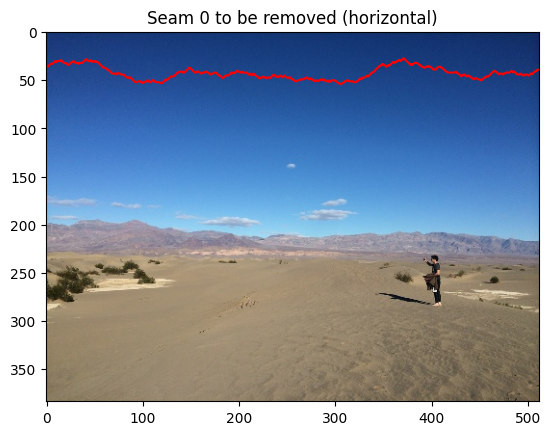

In [ ]:
# Main code:

image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")

newImage = reduceImage(image, 90)

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
f.add_subplot(1, 2, 2)
plt.imshow(newImage)
plt.title("Resized Image")
plt.show(block=True)

print("Original image shape:", image.shape)
print("Resized image shape:", newImage.shape)

C:\Users\Aya Elsheshtawy\AppData\Local\Temp\ipykernel_8872\1350886973.py:92: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")


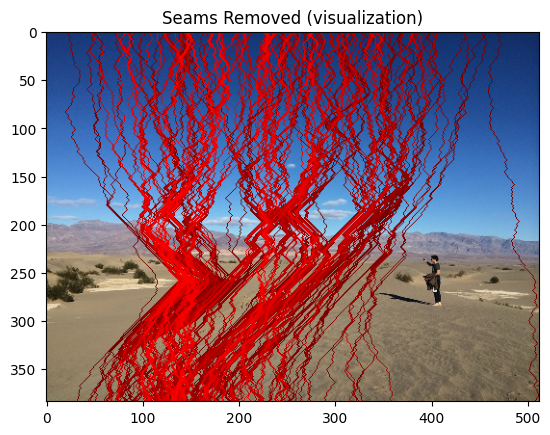

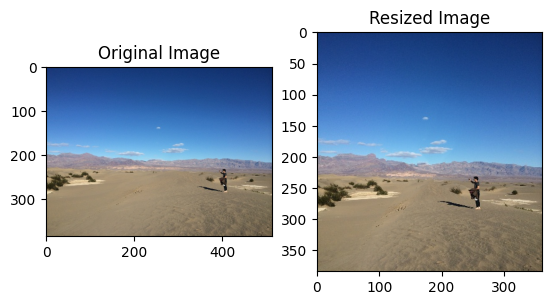

Original shape: (384, 512, 3)
Resized shape: (384, 362, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from imageio import imread

def rgb2gray(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def FindEnergyMap(image):
    gray = rgb2gray(image)
    sobel_x = np.array([[-1,  0,  1], [-2,  0,  2], [-1,  0,  1]])
    sobel_y = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])
    dx = signal.convolve2d(gray, sobel_x, mode='same', boundary='symm')
    dy = signal.convolve2d(gray, sobel_y, mode='same', boundary='symm')
    return np.abs(dx) + np.abs(dy)

def ComputeSeams(energyMap, direction='vertical'):
    row, col = energyMap.shape
    energySums = np.copy(energyMap)
    energySumsCoords = np.zeros((row, col), dtype=int)
    
    if direction == 'vertical':
        for i in range(1, row):
            for j in range(col):
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
        return seam
    
    else:
        for j in range(1, col):
            for i in range(row):
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
        return seam

def reduceImage(image, numSeams):
    newImage = np.copy(image)
    seamPath = np.copy(image)
    index_map = np.arange(image.shape[1]).reshape(1, -1).repeat(image.shape[0], axis=0)
    redVal = 255
    
    for _ in range(numSeams):
        energyMap = FindEnergyMap(newImage)
        seam = ComputeSeams(energyMap, direction='vertical')
        rows, cols, _ = newImage.shape
        
        for i in range(rows):
            j = seam[i]
            seamPath[i, index_map[i, j], 0] = redVal
            seamPath[i, index_map[i, j], 1] = 0
            seamPath[i, index_map[i, j], 2] = 0
            newImage[i, j:cols-1] = newImage[i, j+1:cols]
            index_map[i, j:cols-1] = index_map[i, j+1:cols]
        
        newImage = newImage[:, :cols-1, :]
        index_map = index_map[:, :cols-1]
        redVal -= 1
    
    plt.imshow(seamPath.astype(np.uint8))
    plt.title("Seams Removed (visualization)")
    plt.show()
    return newImage

image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")
newImage = reduceImage(image, 150)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(newImage)
plt.title("Resized Image")
plt.show()
print("Original shape:", image.shape)
print("Resized shape:", newImage.shape)


C:\Users\Aya Elsheshtawy\AppData\Local\Temp\ipykernel_8872\308795142.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")


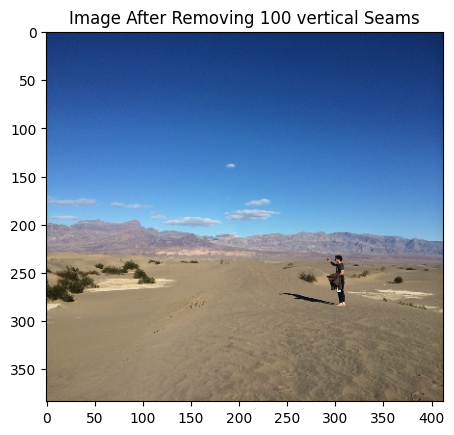

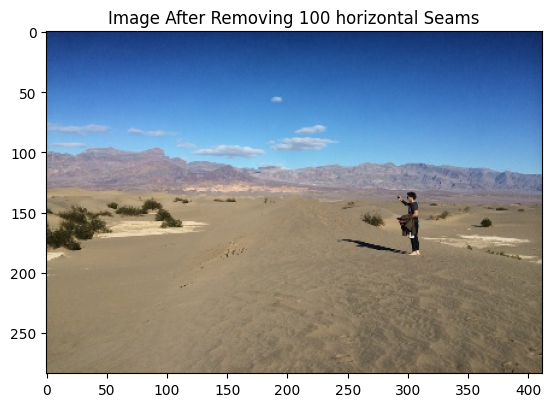

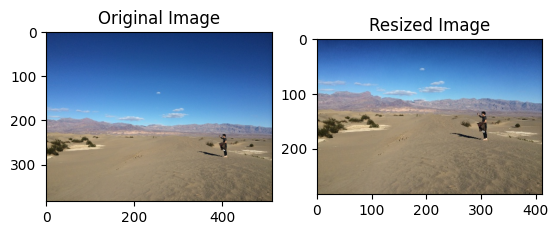

Original shape: (384, 512, 3)
Resized shape: (284, 412, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from imageio import imread

def rgb2gray(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def FindEnergyMap(image):
    gray = rgb2gray(image)
    sobel_x = np.array([[-1,  0,  1], [-2,  0,  2], [-1,  0,  1]])
    sobel_y = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])
    dx = signal.convolve2d(gray, sobel_x, mode='same', boundary='symm')
    dy = signal.convolve2d(gray, sobel_y, mode='same', boundary='symm')
    return np.abs(dx) + np.abs(dy)

def ComputeSeams(energyMap, direction='vertical'):
    row, col = energyMap.shape
    energySums = np.copy(energyMap)
    energySumsCoords = np.zeros((row, col), dtype=int)

    if direction == 'vertical':
        for i in range(1, row):
            for j in range(col):
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
        return seam

    elif direction == 'horizontal':
        for j in range(1, col):
            for i in range(row):
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
        return seam

def reduceImage(image, numSeams, direction='vertical'):
    newImage = np.copy(image)
    seamPath = np.copy(image)
    redVal = 255

    if direction == 'horizontal':
        newImage = np.transpose(newImage, (1, 0, 2))  

    rows, cols, _ = newImage.shape

    for _ in range(numSeams):
        energyMap = FindEnergyMap(newImage)
        seam = ComputeSeams(energyMap, direction='vertical')
        
        # Ensure seam indices are valid
        if len(seam) != rows:
            seam = np.clip(seam, 0, cols - 1)

        newImage = np.array([np.delete(row, seam[i], axis=0) for i, row in enumerate(newImage)])
        
        rows, cols, _ = newImage.shape  
        redVal = max(0, redVal - 1)

    if direction == 'horizontal':
        newImage = np.transpose(newImage, (1, 0, 2))  

    plt.imshow(newImage.astype(np.uint8))
    plt.title(f"Image After Removing {numSeams} {direction} Seams")
    plt.show()
    return newImage

image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")

num_vertical_seams = 100 
num_horizontal_seams =100  

newImage = reduceImage(image, num_vertical_seams, direction='vertical')
newImage = reduceImage(newImage, num_horizontal_seams, direction='horizontal')

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(newImage)
plt.title("Resized Image")

plt.show()

print("Original shape:", image.shape)
print("Resized shape:", newImage.shape)


C:\Users\Aya Elsheshtawy\AppData\Local\Temp\ipykernel_8872\2744548964.py:84: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")


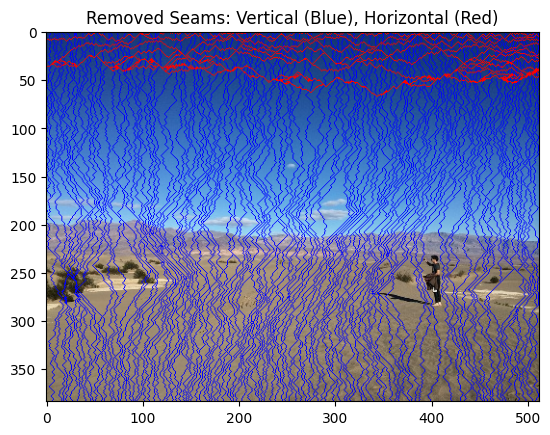

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from imageio import imread

def rgb2gray(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def FindEnergyMap(image):
    gray = rgb2gray(image)
    sobel_x = np.array([[-1,  0,  1], [-2,  0,  2], [-1,  0,  1]])
    sobel_y = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])
    dx = signal.convolve2d(gray, sobel_x, mode='same', boundary='symm')
    dy = signal.convolve2d(gray, sobel_y, mode='same', boundary='symm')
    return np.abs(dx) + np.abs(dy)

def ComputeSeams(energyMap, direction='vertical'):
    row, col = energyMap.shape
    energySums = np.copy(energyMap)
    energySumsCoords = np.zeros((row, col), dtype=int)

    if direction == 'vertical':
        for i in range(1, row):
            for j in range(col):
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
        return seam

    elif direction == 'horizontal':
        for j in range(1, col):
            for i in range(row):
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1
                min_index = np.argmin(prev_vals)
                energySums[i, j] += prev_vals[min_index]
                energySumsCoords[i, j] = offset + min_index
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
        return seam

def visualize_seams(image, numSeams, direction='vertical'):
    seamImage = np.copy(image)
    color = [0, 0, 255] if direction == 'vertical' else [255, 0, 0]  

    for _ in range(numSeams):
        energyMap = FindEnergyMap(seamImage)
        seam = ComputeSeams(energyMap, direction)
        
        if direction == 'horizontal':
            seamImage = np.transpose(seamImage, (1, 0, 2))

        for i in range(seamImage.shape[0]):
            j = seam[i]
            seamImage[i, j] = color  

        if direction == 'horizontal':
            seamImage = np.transpose(seamImage, (1, 0, 2))

    return seamImage

image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")

num_vertical_seams = 100 
num_horizontal_seams = 100  

seamImage = visualize_seams(image, num_vertical_seams, 'vertical')
seamImage = visualize_seams(seamImage, num_horizontal_seams, 'horizontal')

plt.imshow(seamImage.astype(np.uint8))
plt.title("Removed Seams: Vertical (Blue), Horizontal (Red)")
plt.show()
